# Procesamiento de datos de Sentinel-2

## Librerías

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os


## Obtener los datos

In [149]:
filesNacionalesMean = glob.glob("data/sentinel/states/mean/*.csv")
filesNacionalesSum = glob.glob("data/sentinel/states/sum/*.csv")
filesNacionalesSum[:5]

[]

### Diccionarios complementarios

In [150]:
replace_emision = {
  'pm10': '$PM_{10}$',
  'pm2.5': '$PM_{2.5}$',
  'co': '$CO$',
  'nox':'$NO_x$',
  'cov':'$COV$',
  'nh3':'$NH_3$',
  'so2':"$SO_2$",
  'no2':"$NO_2$",
  'o3':"$O_3$",
  'hcho':"$HCHO$",
}


## Preparar función de lectura

In [151]:
def readFileSentinel(path, dfFull, kind):
  cols_to_keep = ['ADM1_NAME',kind]
  name_Quimico = path.split("\\")[1].split("_")[0].lower()
  date = path.split("_")[2][:10]

  df = pd.read_csv(path)
  df = df.drop(columns=["ADM1_CODE","ADM0_CODE","EXP1_YEAR","system:index","STR1_YEAR","STATUS","ADM0_NAME","DISP_AREA"])
  #df.rename(columns={kind: replace_emision[name_Quimico]}, inplace=True)

  df['date'] = date
  df['quimico'] = replace_emision[name_Quimico]
  # check if dfFull is empty
  if dfFull.empty:
    return df
  
  # merge dataframes by ADM1_NAME
  dfFull = pd.concat([dfFull, df], axis=0, ignore_index=True)
  
  return dfFull

## Leer datos 

### Datos de acumulado (anuales por estado)

In [152]:
dfFullSum = pd.DataFrame()

for path in filesNacionalesSum:
  
  dfFullSum = readFileSentinel(path, dfFullSum, 'sum')
  
dfFullSum.head()

""


## Ajustar datos geográficos

### AGEBS Colima

In [153]:
import geopandas as gpd

agebs_area = gpd.read_file("data/06_colima/06a.shp")

# compute area in km2
agebs_area['area_m2'] = agebs_area['geometry'].area # / 10**6

# make CVE_ENT, CVE_MUN, CVE_LOC columns to int
agebs_area['CVE_ENT'] = agebs_area['CVE_ENT'].astype(int)
agebs_area['CVE_MUN'] = agebs_area['CVE_MUN'].astype(int)
agebs_area['CVE_LOC'] = agebs_area['CVE_LOC'].astype(int)
agebs_area

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry,area_m2
0,0600100010081,6,1,1,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104
1,060010001019A,6,1,1,019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ...",150531.641361
2,0600100010359,6,1,1,0359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ...",53900.872844
3,0600100010151,6,1,1,0151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ...",418612.515706
4,0600100010166,6,1,1,0166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ...",403632.598077
...,...,...,...,...,...,...,...,...
546,0601000011017,6,10,1,1017,0.21,"POLYGON ((2319827.994 811244.081, 2319759.033 ...",207685.105225
547,0601000011178,6,10,1,1178,0.08,"POLYGON ((2317403.972 811570.582, 2317381.354 ...",84047.033089
548,0601000011144,6,10,1,1144,0.39,"POLYGON ((2315441.563 810543.627, 2315414.299 ...",388599.351038
549,060100001113A,6,10,1,113A,0.32,"POLYGON ((2315467.707 808779.738, 2315450.836 ...",313390.019937


### Municipios Nacional

In [154]:
files_nacional = glob.glob("data/mexico/*.csv")
files_nacional

['data/mexico\\areas_geoestadisticas_municipales.csv',
 'data/mexico\\localidades_urbanas_y_rurales_amanzanadas.csv']

In [155]:
mun_nacional = pd.read_csv("data/mexico/areas_geoestadisticas_municipales.csv", skiprows=2, encoding="latin-1")
mun_nacional.rename(columns={
  "Clave Geoestadística Estatal": "CVE_ENT", 
  "Clave Geoestadística Municipal": "CVE_MUN", 
  "Nombre del Municipio": "NOM_MUN", 
  "Nombre del Estado": "NOM_ENT"}, inplace=True)

mun_colima = mun_nacional[mun_nacional["CVE_ENT"] == 6]
mun_colima.head()

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN
74,6,Colima,1,Armería
75,6,Colima,2,Colima
76,6,Colima,3,Comala
77,6,Colima,4,Coquimatlán
78,6,Colima,5,Cuauhtémoc


### Localidades Nacional

In [156]:
loc_nacional = pd.read_csv("data/mexico/localidades_urbanas_y_rurales_amanzanadas.csv", skiprows=2, encoding="latin-1")
loc_nacional.rename(columns={
  "Clave Geoestadística Estatal": "CVE_ENT", 
  "Clave Geoestadís  tica Municipal": "CVE_MUN", 
  "Clave Geoestadística de Localidad": "CVE_LOC",
  "Nombre de Localidad": "NOM_LOC",
  "AGEB":'CVE_AGEB'}, inplace=True)
loc_nacional.drop(columns=["Unnamed: 6","CVE_AGEB"], inplace=True)
loc_nacional = loc_nacional[loc_nacional["CVE_ENT"] == 6]
loc_nacional.head()

,CVE_ENT,CVE_MUN,CVE_LOC,NOM_LOC,Ámbito
2455,6,1,1,Ciudad de Armería,U
2456,6,1,7,Cofradía de Juárez,U
2457,6,1,9,Cuyutlán,R
2458,6,1,32,El Paraíso [Balneario],R
2459,6,1,33,Periquillo,R


### Merge localidades y municipios

In [157]:
colima = pd.merge(mun_colima, loc_nacional, on=["CVE_ENT", "CVE_MUN"])
colima

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,Ámbito
0,6,Colima,1,Armería,1,Ciudad de Armería,U
1,6,Colima,1,Armería,7,Cofradía de Juárez,U
2,6,Colima,1,Armería,9,Cuyutlán,R
3,6,Colima,1,Armería,32,El Paraíso [Balneario],R
4,6,Colima,1,Armería,33,Periquillo,R
...,...,...,...,...,...,...,...
161,6,Colima,10,Villa de Álvarez,22,El Mixcuate,R
162,6,Colima,10,Villa de Álvarez,24,El Naranjal,R
163,6,Colima,10,Villa de Álvarez,37,Pueblo Nuevo,R
164,6,Colima,10,Villa de Álvarez,86,El Nuevo Naranjal,R


In [158]:
agebs_area

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry,area_m2
0,0600100010081,6,1,1,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104
1,060010001019A,6,1,1,019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ...",150531.641361
2,0600100010359,6,1,1,0359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ...",53900.872844
3,0600100010151,6,1,1,0151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ...",418612.515706
4,0600100010166,6,1,1,0166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ...",403632.598077
...,...,...,...,...,...,...,...,...
546,0601000011017,6,10,1,1017,0.21,"POLYGON ((2319827.994 811244.081, 2319759.033 ...",207685.105225
547,0601000011178,6,10,1,1178,0.08,"POLYGON ((2317403.972 811570.582, 2317381.354 ...",84047.033089
548,0601000011144,6,10,1,1144,0.39,"POLYGON ((2315441.563 810543.627, 2315414.299 ...",388599.351038
549,060100001113A,6,10,1,113A,0.32,"POLYGON ((2315467.707 808779.738, 2315450.836 ...",313390.019937


In [159]:
agebs_colima = gpd.GeoDataFrame(pd.merge(agebs_area, colima, on=["CVE_ENT", "CVE_MUN", "CVE_LOC"]))
agebs_colima

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry,area_m2,NOM_ENT,NOM_MUN,NOM_LOC,Ámbito
0,0600100010081,6,1,1,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
1,060010001019A,6,1,1,019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ...",150531.641361,Colima,Armería,Ciudad de Armería,U
2,0600100010359,6,1,1,0359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ...",53900.872844,Colima,Armería,Ciudad de Armería,U
3,0600100010151,6,1,1,0151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ...",418612.515706,Colima,Armería,Ciudad de Armería,U
4,0600100010166,6,1,1,0166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ...",403632.598077,Colima,Armería,Ciudad de Armería,U
...,...,...,...,...,...,...,...,...,...,...,...,...
546,0601000011017,6,10,1,1017,0.21,"POLYGON ((2319827.994 811244.081, 2319759.033 ...",207685.105225,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
547,0601000011178,6,10,1,1178,0.08,"POLYGON ((2317403.972 811570.582, 2317381.354 ...",84047.033089,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
548,0601000011144,6,10,1,1144,0.39,"POLYGON ((2315441.563 810543.627, 2315414.299 ...",388599.351038,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
549,060100001113A,6,10,1,113A,0.32,"POLYGON ((2315467.707 808779.738, 2315450.836 ...",313390.019937,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U


## Datos por estado

In [160]:
import geopandas as gpd
mexico_shape = gpd.read_file("data/mexico/00ent.shp")
mexico_shape['area'] = mexico_shape['geometry'].area
mexico_shape.head()

,CVEGEO,CVE_ENT,NOMGEO,geometry,area
0,01,01,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5.558674e+09
1,02,02,Baja California,"MULTIPOLYGON (((1493197.165 1849625.247, 14934...",7.351674e+10
2,03,03,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.638, 16946...",7.397069e+10
3,04,04,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",5.725451e+10
4,05,05,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",1.506712e+11


In [161]:
mexico_shape.NOMGEO.unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'México', 'Michoacán de Ocampo',
       'Morelos', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla',
       'Querétaro', 'Quintana Roo', 'San Luis Potosí', 'Sinaloa',
       'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas'],
      dtype=object)

In [162]:
names_bad = [
  'Aguascalientes', 'Baja California', 
'Baja California Sur','Campeche', 'Chiapas', 'Chihuahua', 'Coahuila', 'Colima','Distrito Federal', 'Durango', 'Guanajuato', 
'Guerrero', 'Hidalgo','Jalisco', 'Mexico', 'Michoacan', 'Morelos', 'Nayarit','Nuevo Leon', 'Oaxaca', 'Puebla', 
'Queretaro', 'Quintana Roo','San Luis Potosi', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas','Tlaxcala', 'Veracruz', 'Yucatan', 'Zacatecas']

names_good = ['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'México', 'Michoacán de Ocampo',
       'Morelos', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla',
       'Querétaro', 'Quintana Roo', 'San Luis Potosí', 'Sinaloa',
       'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas']

# create a dictionary with the bad names as keys and the good names as values
names_dict = dict(zip(names_bad, names_good))



In [163]:
nacional_sentinel = glob.glob("data/sentinel/mexico_states/year/*.csv")
nacional_sentinel[:5]

['data/sentinel/mexico_states/year\\sum_CO_2018-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2019-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2020-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2021-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2022-01-01.csv']

In [164]:
def readNacionalSentinel(path, dfFull):
  df = pd.read_csv(path)
  
  df = df[["ADM1_NAME","Shape_Area","sum"]]
  date = path.split("_")[3][:4]
  name_Quimico = path.split("_")[2].lower()
  
  df["year"] = date
  df['quimico'] = replace_emision[name_Quimico]
  
  #rename ADM1_NAME with names_dict
  df['ADM1_NAME'] = df['ADM1_NAME'].map(names_dict)
  
  df = pd.concat([df, dfFull], axis=0, ignore_index=True)
  return df


nacionaSentinelDf = pd.DataFrame()

for path in nacional_sentinel:
  nacionaSentinelDf = readNacionalSentinel(path, nacionaSentinelDf)

nacionaSentinelDf = nacionaSentinelDf.merge(mexico_shape, left_on='ADM1_NAME', right_on='NOMGEO')

nacionaSentinelDf.head()

,ADM1_NAME,Shape_Area,sum,year,quimico,CVEGEO,CVE_ENT,NOMGEO,geometry,area
0,Aguascalientes,0.455086,0.666021,2022,$SO_2$,01,01,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5.558674e+09
1,Aguascalientes,0.455086,1.114923,2021,$SO_2$,01,01,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5.558674e+09
2,Aguascalientes,0.455086,1.391307,2020,$SO_2$,01,01,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5.558674e+09
3,Aguascalientes,0.455086,0.687528,2019,$SO_2$,01,01,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5.558674e+09
4,Aguascalientes,0.455086,0.281939,2018,$SO_2$,01,01,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5.558674e+09


In [188]:
medias_nacionales = nacionaSentinelDf.groupby(["ADM1_NAME","quimico",'area'], as_index=False).agg({"sum":"sum"})
#medias_nacionales['value'] = medias_nacionales['sum'] * medias_nacionales['area']
medias_nacionales = medias_nacionales.groupby(["quimico"], as_index=False).agg({"sum":"mean"})
medias_nacionales

# medias_nacionales to dict 
medias_nacionales_dict = medias_nacionales.set_index('quimico').T.to_dict('list')
medias_nacionales_dict

{'$CO$': [17871.586348562363],
 '$HCHO$': [71.79222469243946],
 '$NO_2$': [50.80729784164897],
 '$O_3$': [104851.65706097132],
 '$SO_2$': [49.28037763095691]}

## Datos por municipio de Colima

In [166]:
mun_sentinel = glob.glob("data/sentinel/municipios/year/*.csv")
mun_sentinel[:5]

['data/sentinel/municipios/year\\sum_CO_2022-01-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2018-07-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2019-07-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2020-07-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2021-07-01.csv']

In [167]:
rename_mun = {'Armeria': 'Armería',
 'Coquimatlan': 'Coquimatlán',
 'Cuauhtemoc': 'Cuauhtémoc',
 'Ixtlahuacan': 'Ixtlahuacán',
 'Minatitlan': 'Minatitlán',
 'Tecoman': 'Tecomán',
 'Villa De Alvarez': 'Villa de Álvarez'}


In [168]:
def readMunSentinel(path, dfFull):
  df = pd.read_csv(path)

  df = df[["ADM2_NAME","Shape_Area","sum"]]
  
  date = path.split("_")[2][:4]
  name_Quimico = path.split("_")[1].lower()
  
  df["date"] = date
  df['quimico'] = replace_emision[name_Quimico]

  # replace values on ADM2_NAME using rename_mun dict
  df["ADM2_NAME"] = df["ADM2_NAME"].replace(rename_mun)
  
  df = pd.concat([df, dfFull], axis=0, ignore_index=True)
  
  
  return df

dfMunSentinel = pd.DataFrame()

for path in mun_sentinel:
  dfMunSentinel = readMunSentinel(path, dfMunSentinel)

dfMunSentinel.head()

dfMunSentinel_groupes = dfMunSentinel.groupby(["quimico","ADM2_NAME"], as_index=False).agg({"sum":"sum", "Shape_Area":"mean"})
dfMunSentinel.head()

,ADM2_NAME,Shape_Area,sum,date,quimico
0,Armería,0.047960,3.528632,2022,$SO_2$
1,Colima,0.059419,4.438458,2022,$SO_2$
2,Comala,0.025622,1.476824,2022,$SO_2$
3,Coquimatlán,0.041502,2.827256,2022,$SO_2$
4,Cuauhtémoc,0.040930,1.984836,2022,$SO_2$


In [169]:
dfMunSentinel_groupes["value"] = dfMunSentinel_groupes["sum"] * dfMunSentinel_groupes["Shape_Area"]

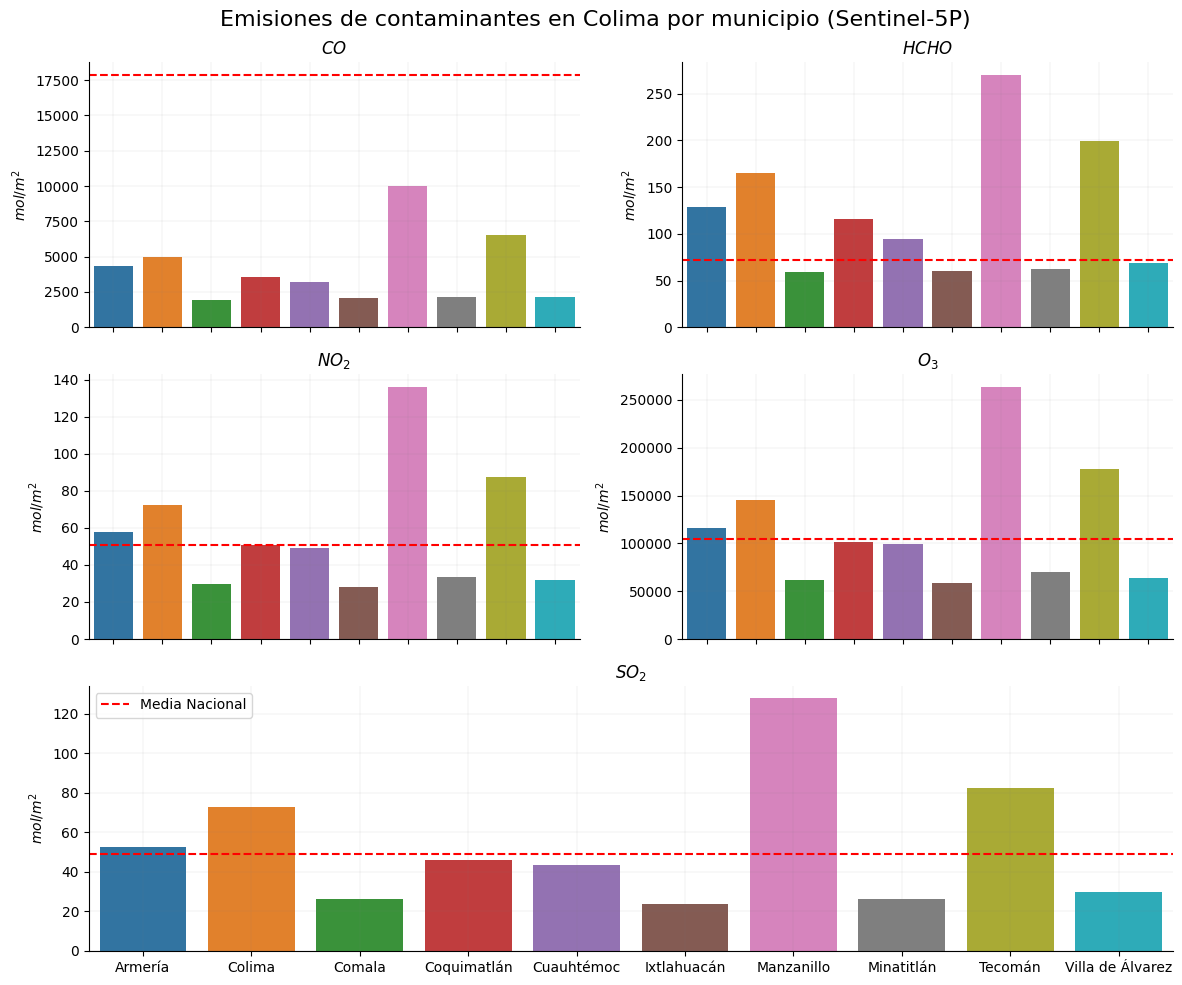

In [189]:
nQuimicos = len(dfMunSentinel_groupes["quimico"].unique())

fig, ax = plt.subplots(figsize=(12, 10), ncols=2, nrows=3, sharex=True)

col = 0
row = 0
gs = ax[2,0].get_gridspec()

for emision, quimicoDF in dfMunSentinel_groupes.groupby("quimico"):
  
  ax[row, col].set_title(emision, fontweight="bold")
  sns.barplot(x="ADM2_NAME", y="sum", data=quimicoDF, ax=ax[row, col])
  ax[row, col].set_xlabel("")
  ax[row, col].set_ylabel("$mol/m^2$")
  # set ylim 10% higher than max value in "emisiones" column
  ax[row, col].grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)  
  
  # set hline for national average 
  ax[row, col].axhline(medias_nacionales_dict[emision][0], color="red", linestyle="--", label="Media Nacional")
  ax[row, col].legend().set_visible(False)
  
  col += 1
  if col == 2:
    col = 0
    row += 1
    
    
for axe in ax[2,:]:
    axe.remove()
    
axbig = fig.add_subplot(gs[2, :])


axbig.set_title(emision, fontweight="bold")
sns.barplot(x="ADM2_NAME", y="sum", data=quimicoDF, ax=axbig)
axbig.axhline(medias_nacionales_dict[emision][0], color="red", linestyle="--", label="Media Nacional")
axbig.set_xlabel("")
axbig.set_ylabel("$mol/m^2$")
axbig.grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)
#axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)
axbig.legend(fancybox=True, loc="upper left")

# Increase space between subplots
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Emisiones de contaminantes en Colima por municipio (Sentinel-5P)", fontsize=16) 
sns.despine()
plt.tight_layout()
plt.savefig("img/sentinel/emisiones_municipios_sentinel.png", dpi=300)
plt.show()

## Datos de AGEBS (mensuales por ageb)

In [171]:
agebs_files = glob.glob("data/sentinel/AGEBS/month/*.csv")
print(len(agebs_files))
agebs_files[:5]

255


['data/sentinel/AGEBS/month\\sum_CO_2018-11-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2018-12-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-01-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-02-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-03-01.csv']

In [172]:
def readAgebMonthly(path, dfFull):
  df = pd.read_csv(path)
  df.drop(columns=["system:index"], inplace=True)
  name_Quimico = path.split("_")[1].lower()
  
  date = path.split("_")[2][:10]
  
  df['quimico'] = replace_emision[name_Quimico]
  df['date'] = pd.to_datetime(date)
  
  # if sum is less than 0, set it to 0
  #df["sum"] = df["sum"].apply(lambda x: 0 if x < 0 else x)
  
  df = pd.concat([dfFull, df], axis=0, ignore_index=True)
  return df

dfFullAgebs = pd.DataFrame()

for path in agebs_files:
  dfFullAgebs = readAgebMonthly(path, dfFullAgebs)
print(dfFullAgebs.quimico.unique())
dfFullAgebs

['$CO$' '$HCHO$' '$NO_2$' '$O_3$' '$SO_2$']


,sum,CVE_LOC,CVE_MUN,CVE_ENT,CVEGEO,CVE_AGEB,quimico,date
0,0.052075,1,1,6,0600100010081,0081,$CO$,2018-11-01
1,0.023302,1,1,6,060010001019A,019A,$CO$,2018-11-01
2,0.008745,1,1,6,0600100010359,0359,$CO$,2018-11-01
3,0.077275,1,1,6,0600100010151,0151,$CO$,2018-11-01
4,0.076924,1,1,6,0600100010166,0166,$CO$,2018-11-01
...,...,...,...,...,...,...,...,...
140500,0.000618,1,10,6,0601000011017,1017,$SO_2$,2022-11-01
140501,-0.000151,1,10,6,0601000011178,1178,$SO_2$,2022-11-01
140502,-0.000315,1,10,6,0601000011144,1144,$SO_2$,2022-11-01
140503,-0.000038,1,10,6,060100001113A,113A,$SO_2$,2022-11-01


In [173]:
dfFullAgebs = pd.merge(dfFullAgebs, agebs_colima, on=["CVEGEO", "CVE_ENT", "CVE_MUN", "CVE_LOC","CVE_AGEB"])
dfFullAgebs

,sum,CVE_LOC,CVE_MUN,CVE_ENT,CVEGEO,CVE_AGEB,quimico,date,area,geometry,area_m2,NOM_ENT,NOM_MUN,NOM_LOC,Ámbito
0,0.052075,1,1,6,0600100010081,0081,$CO$,2018-11-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
1,0.151151,1,1,6,0600100010081,0081,$CO$,2018-12-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
2,0.211080,1,1,6,0600100010081,0081,$CO$,2019-01-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
3,0.226947,1,1,6,0600100010081,0081,$CO$,2019-02-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
4,0.272456,1,1,6,0600100010081,0081,$CO$,2019-03-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140500,0.001144,1,10,6,0601000011375,1375,$SO_2$,2022-07-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140501,0.000199,1,10,6,0601000011375,1375,$SO_2$,2022-08-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140502,0.000378,1,10,6,0601000011375,1375,$SO_2$,2022-09-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140503,0.000413,1,10,6,0601000011375,1375,$SO_2$,2022-10-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U


In [174]:
dfFullAgebs_total = dfFullAgebs.groupby(["NOM_MUN","quimico","date"]).agg({"sum": "sum",'area_m2':"sum"}).reset_index()
dfFullAgebs_total

,NOM_MUN,quimico,date,sum,area_m2
0,Armería,$CO$,2018-11-01,1.232826,6.771151e+06
1,Armería,$CO$,2018-12-01,3.725024,6.771151e+06
2,Armería,$CO$,2019-01-01,4.885068,6.771151e+06
3,Armería,$CO$,2019-02-01,5.255419,6.771151e+06
4,Armería,$CO$,2019-03-01,6.614434,6.771151e+06
...,...,...,...,...,...
2545,Villa de Álvarez,$SO_2$,2022-07-01,0.072758,2.466407e+07
2546,Villa de Álvarez,$SO_2$,2022-08-01,0.010969,2.466407e+07
2547,Villa de Álvarez,$SO_2$,2022-09-01,0.020898,2.466407e+07
2548,Villa de Álvarez,$SO_2$,2022-10-01,-0.004131,2.466407e+07


In [175]:
dfFullAgebs_total['value']  = dfFullAgebs_total['sum'] * dfFullAgebs_total['area_m2']

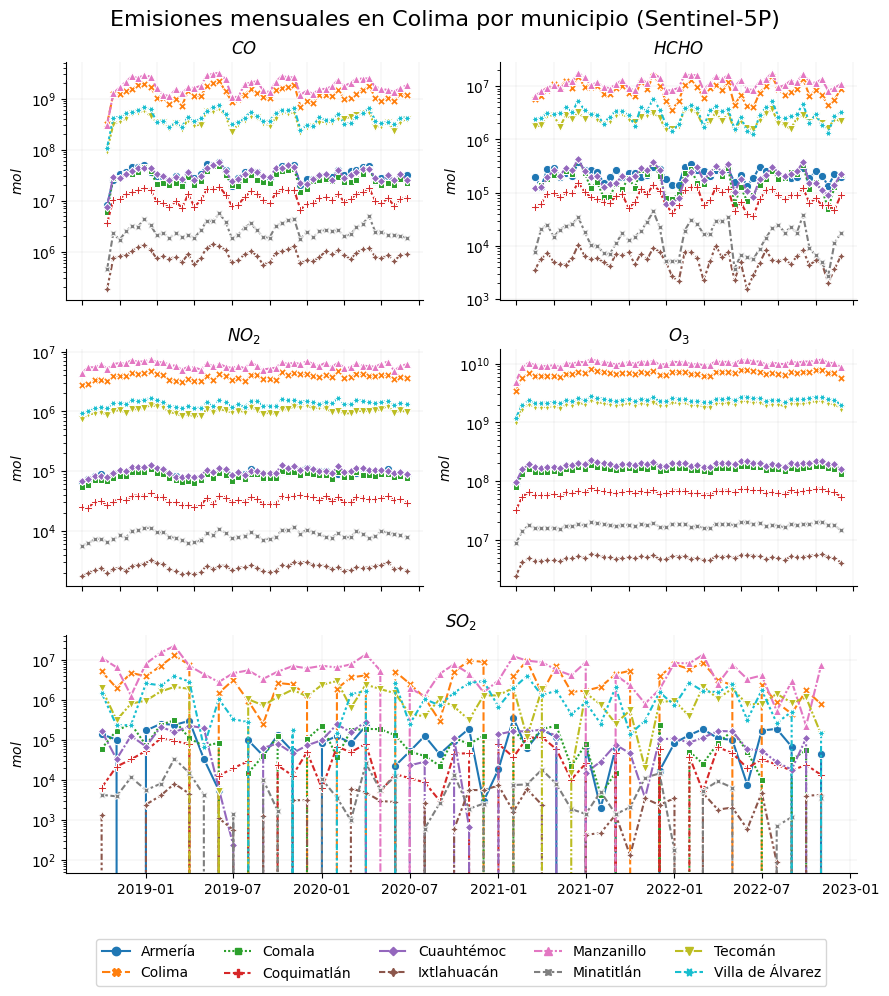

In [176]:
nQuimicos = len(dfFullAgebs_total["quimico"].unique())

fig, ax = plt.subplots(figsize=(9, 10), ncols=2, nrows=3, sharex=True)

col = 0
row = 0
gs = ax[2,0].get_gridspec()

for emision, quimicoDF in dfFullAgebs_total.groupby("quimico"):
  
  ax[row, col].set_title(emision, fontweight="bold")

  sns.lineplot(x="date", y="value", data=quimicoDF, ax=ax[row, col], hue="NOM_MUN", style="NOM_MUN", markers=True, dashes=True)
  ax[row, col].set_yscale("log")
  ax[row, col].set_xlabel("")
  ax[row, col].set_ylabel("$mol$")
  # set ylim 10% higher than max value in "emisiones" column
  ax[row, col].grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)  
  
  # set hline for national average 

  ax[row, col].legend().set_visible(False)
  
  col += 1
  if col == 2:
    col = 0
    row += 1
    
    
for axe in ax[2,:]:
    axe.remove()
    
axbig = fig.add_subplot(gs[2, :])


axbig.set_title(emision, fontweight="bold")
sns.lineplot(x="date", y="value", data=quimicoDF, ax=axbig, hue="NOM_MUN", style="NOM_MUN", markers=True, dashes=True)
axbig.set_yscale("log")
axbig.set_xlabel("")
axbig.set_ylabel("$mol$")
axbig.grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)
#axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)
axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)

# Increase space between subplots
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Emisiones mensuales en Colima por municipio (Sentinel-5P)", fontsize=16) 
sns.despine()
plt.tight_layout()
plt.savefig("img/sentinel/timeline_mund_sentinel.png", dpi=300)
plt.show()

In [177]:
agebs_colima = agebs_colima.drop(columns=["CVE_ENT", "CVE_MUN", "CVE_LOC"])
agebs_colima

,CVEGEO,CVE_AGEB,area,geometry,area_m2,NOM_ENT,NOM_MUN,NOM_LOC,Ámbito
0,0600100010081,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
1,060010001019A,019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ...",150531.641361,Colima,Armería,Ciudad de Armería,U
2,0600100010359,0359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ...",53900.872844,Colima,Armería,Ciudad de Armería,U
3,0600100010151,0151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ...",418612.515706,Colima,Armería,Ciudad de Armería,U
4,0600100010166,0166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ...",403632.598077,Colima,Armería,Ciudad de Armería,U
...,...,...,...,...,...,...,...,...,...
546,0601000011017,1017,0.21,"POLYGON ((2319827.994 811244.081, 2319759.033 ...",207685.105225,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
547,0601000011178,1178,0.08,"POLYGON ((2317403.972 811570.582, 2317381.354 ...",84047.033089,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
548,0601000011144,1144,0.39,"POLYGON ((2315441.563 810543.627, 2315414.299 ...",388599.351038,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
549,060100001113A,113A,0.32,"POLYGON ((2315467.707 808779.738, 2315450.836 ...",313390.019937,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U


In [184]:
dfFullAgebs

,sum,CVE_LOC,CVE_MUN,CVE_ENT,CVEGEO,CVE_AGEB,quimico,date,area,geometry,area_m2,NOM_ENT,NOM_MUN,NOM_LOC,Ámbito
0,0.052075,1,1,6,0600100010081,0081,$CO$,2018-11-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
1,0.151151,1,1,6,0600100010081,0081,$CO$,2018-12-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
2,0.211080,1,1,6,0600100010081,0081,$CO$,2019-01-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
3,0.226947,1,1,6,0600100010081,0081,$CO$,2019-02-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
4,0.272456,1,1,6,0600100010081,0081,$CO$,2019-03-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140500,0.001144,1,10,6,0601000011375,1375,$SO_2$,2022-07-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140501,0.000199,1,10,6,0601000011375,1375,$SO_2$,2022-08-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140502,0.000378,1,10,6,0601000011375,1375,$SO_2$,2022-09-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140503,0.000413,1,10,6,0601000011375,1375,$SO_2$,2022-10-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U


In [185]:
#dfFullAgebs_shape = dfFullAgebs.groupby(["NOM_MUN","quimico","date"]).agg({"sum": "sum",'area':"sum"}).reset_index()
dfFullAgebs1 = dfFullAgebs[["CVEGEO","CVE_AGEB","quimico","date", "sum", "area_m2", "NOM_MUN"]]

In [186]:
dfFullAgebs2 = dfFullAgebs1.groupby(["NOM_MUN","CVEGEO","CVE_AGEB","quimico"]).agg({"sum": "sum", "area_m2":'mean'}).reset_index()
dfFullAgebs2['value'] = dfFullAgebs2['sum'] * dfFullAgebs2['area_m2']
dfFullAgebs2

,NOM_MUN,CVEGEO,CVE_AGEB,quimico,sum,area_m2,value
0,Armería,0600100010081,0081,$CO$,10.388556,282492.787104,2.934692e+06
1,Armería,0600100010081,0081,$HCHO$,0.073061,282492.787104,2.063909e+04
2,Armería,0600100010081,0081,$NO_2$,0.030311,282492.787104,8.562540e+03
3,Armería,0600100010081,0081,$O_3$,60.232226,282492.787104,1.701517e+07
4,Armería,0600100010081,0081,$SO_2$,0.027385,282492.787104,7.736112e+03
...,...,...,...,...,...,...,...
2750,Villa de Álvarez,060100001138A,138A,$CO$,1.709993,52819.207768,9.032049e+04
2751,Villa de Álvarez,060100001138A,138A,$HCHO$,0.012289,52819.207768,6.491095e+02
2752,Villa de Álvarez,060100001138A,138A,$NO_2$,0.005586,52819.207768,2.950334e+02
2753,Villa de Álvarez,060100001138A,138A,$O_3$,10.049875,52819.207768,5.308264e+05


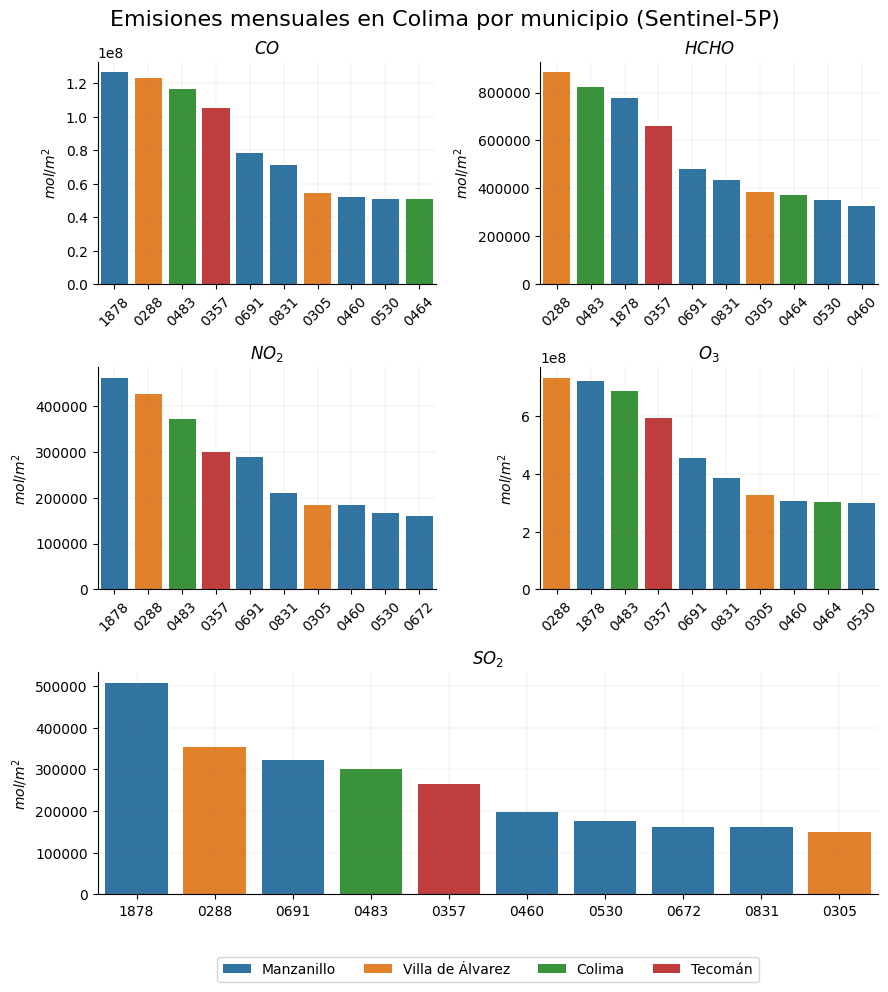

In [206]:
nQuimicos = len(dfFullAgebs2["quimico"].unique())

fig, ax = plt.subplots(figsize=(9, 10), ncols=2, nrows=3)

col = 0
row = 0
gs = ax[2,0].get_gridspec()

for emision, quimicoDF in dfFullAgebs2.groupby("quimico"):
  
  quimicoDF.sort_values(by="value", ascending=False , inplace=True)
  quimicoDF = quimicoDF.head(10)
  ax[row, col].set_title(emision, fontweight="bold")

  sns.barplot(x="CVE_AGEB", y="value", data=quimicoDF, ax=ax[row, col], hue="NOM_MUN", dodge=False, hue_order=['Manzanillo', 'Villa de Álvarez', 'Colima', 'Tecomán'])
  
  ax[row, col].set_xlabel("")
  ax[row, col].set_ylabel("$mol/m^2$")
  # set ylim 10% higher than max value in "emisiones" column
  ax[row, col].grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)  
  
  # rotate xticks 45 degrees
  ax[row, col].tick_params(axis='x', rotation=45)

  ax[row, col].legend().set_visible(False)
  
  col += 1
  if col == 2:
    col = 0
    row += 1
    
    
for axe in ax[2,:]:
    axe.remove()
    
axbig = fig.add_subplot(gs[2, :])


axbig.set_title(emision, fontweight="bold")
sns.barplot(x="CVE_AGEB", y="value", data=quimicoDF, ax=axbig, hue="NOM_MUN", dodge=False)

# make labels equals between subplots

axbig.set_xlabel("")
axbig.set_ylabel("$mol/m^2$")
axbig.grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)
#axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)
axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)

# Increase space between subplots
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Emisiones mensuales en Colima por AGEBS (Sentinel-5P)", fontsize=16) 
sns.despine()
plt.tight_layout()
plt.savefig("img/sentinel/barplot_agebs_sentinel.png", dpi=300)
plt.show() 

In [210]:
dfFullAgebs2.head()

,NOM_MUN,CVEGEO,CVE_AGEB,quimico,sum,area_m2,value
0,Armería,0600100010081,0081,$CO$,10.388556,282492.787104,2.934692e+06
1,Armería,0600100010081,0081,$HCHO$,0.073061,282492.787104,2.063909e+04
2,Armería,0600100010081,0081,$NO_2$,0.030311,282492.787104,8.562540e+03
3,Armería,0600100010081,0081,$O_3$,60.232226,282492.787104,1.701517e+07
4,Armería,0600100010081,0081,$SO_2$,0.027385,282492.787104,7.736112e+03


#### Indices de marginación

In [230]:
imu = pd.read_excel("DATA/IM/IMU_2020.xls", sheet_name="IMU_2020")
imu = imu[imu['ENT'] == 6]
imu1 = imu.copy()
imu = imu[["CVE_AGEB","POB_TOTAL","GM_2020"]]
imu.head()

,CVE_AGEB,POB_TOTAL,GM_2020
4815,0600100010081,1389,Medio
4816,0600100010109,1856,Medio
4817,0600100010147,1078,Medio
4818,0600100010151,1671,Medio
4819,0600100010166,1463,Alto


In [223]:
agebsIM = pd.merge(dfFullAgebs2, imu, left_on="CVEGEO", right_on="CVE_AGEB", how="left")
agebsIM

,NOM_MUN,CVEGEO,CVE_AGEB_x,quimico,sum,area_m2,value,CVE_AGEB_y,POB_TOTAL,GM_2020
0,Armería,0600100010081,0081,$CO$,10.388556,282492.787104,2.934692e+06,0600100010081,1389.0,Medio
1,Armería,0600100010081,0081,$HCHO$,0.073061,282492.787104,2.063909e+04,0600100010081,1389.0,Medio
2,Armería,0600100010081,0081,$NO_2$,0.030311,282492.787104,8.562540e+03,0600100010081,1389.0,Medio
3,Armería,0600100010081,0081,$O_3$,60.232226,282492.787104,1.701517e+07,0600100010081,1389.0,Medio
4,Armería,0600100010081,0081,$SO_2$,0.027385,282492.787104,7.736112e+03,0600100010081,1389.0,Medio
...,...,...,...,...,...,...,...,...,...,...
2750,Villa de Álvarez,060100001138A,138A,$CO$,1.709993,52819.207768,9.032049e+04,060100001138A,126.0,Muy bajo
2751,Villa de Álvarez,060100001138A,138A,$HCHO$,0.012289,52819.207768,6.491095e+02,060100001138A,126.0,Muy bajo
2752,Villa de Álvarez,060100001138A,138A,$NO_2$,0.005586,52819.207768,2.950334e+02,060100001138A,126.0,Muy bajo
2753,Villa de Álvarez,060100001138A,138A,$O_3$,10.049875,52819.207768,5.308264e+05,060100001138A,126.0,Muy bajo


In [225]:
agebsIM['densidad'] = agebsIM['POB_TOTAL'] / agebsIM['area_m2']
agebsIM['value'] = agebsIM['sum'] / agebsIM['densidad']
agebsIM.head()

,NOM_MUN,CVEGEO,CVE_AGEB_x,quimico,sum,area_m2,value,CVE_AGEB_y,POB_TOTAL,GM_2020,densidad
0,Armería,0600100010081,0081,$CO$,10.388556,282492.787104,2112.809324,0600100010081,1389.0,Medio,0.004917
1,Armería,0600100010081,0081,$HCHO$,0.073061,282492.787104,14.858957,0600100010081,1389.0,Medio,0.004917
2,Armería,0600100010081,0081,$NO_2$,0.030311,282492.787104,6.164536,0600100010081,1389.0,Medio,0.004917
3,Armería,0600100010081,0081,$O_3$,60.232226,282492.787104,12249.941957,0600100010081,1389.0,Medio,0.004917
4,Armería,0600100010081,0081,$SO_2$,0.027385,282492.787104,5.569555,0600100010081,1389.0,Medio,0.004917


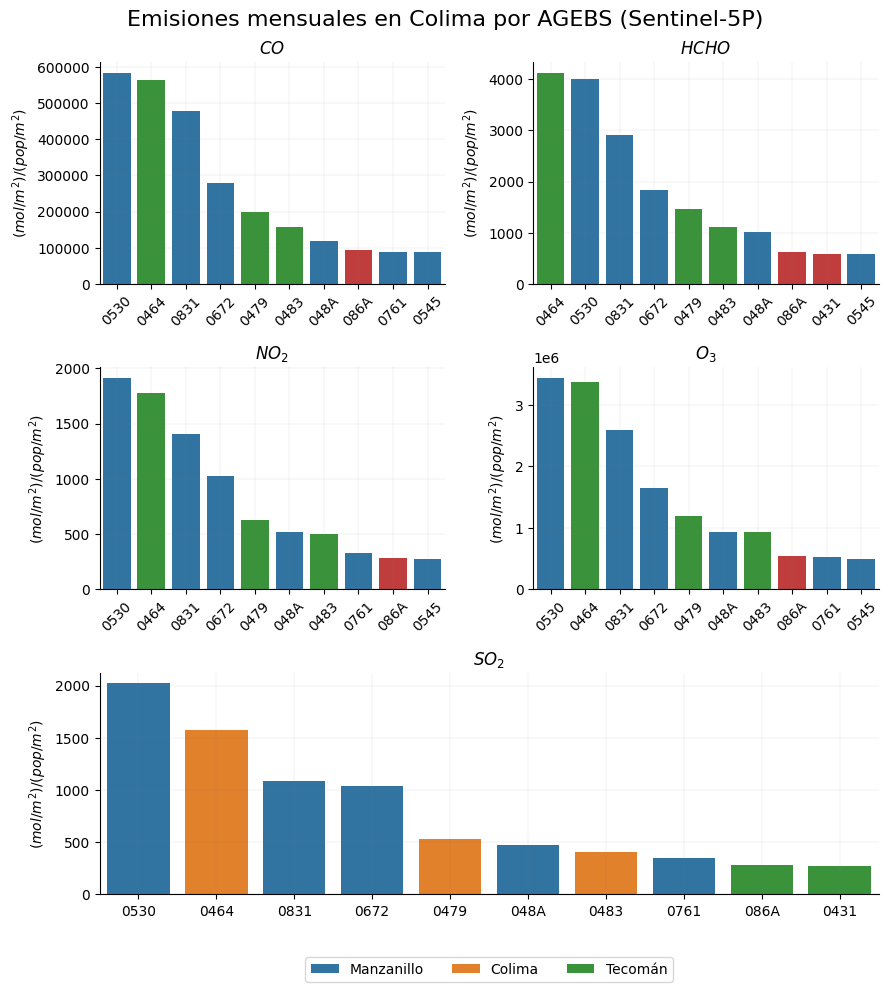

In [233]:
nQuimicos = len(agebsIM["quimico"].unique())

fig, ax = plt.subplots(figsize=(9, 10), ncols=2, nrows=3)

col = 0
row = 0
gs = ax[2,0].get_gridspec()

list_CVE_AGEB = []

for emision, quimicoDF in agebsIM.groupby("quimico"):
  
  quimicoDF.sort_values(by="value", ascending=False , inplace=True)
  quimicoDF = quimicoDF.head(10)
  
  list_CVE_AGEB.append(quimicoDF["CVE_AGEB_y"].tolist())
  
  ax[row, col].set_title(emision, fontweight="bold")

  sns.barplot(x="CVE_AGEB_x", y="value", data=quimicoDF, ax=ax[row, col], hue="NOM_MUN", dodge=False, hue_order=['Manzanillo', 'Villa de Álvarez', 'Colima', 'Tecomán'])
  
  ax[row, col].set_xlabel("")
  ax[row, col].set_ylabel("$(mol/m^2) / (pop/m^2)$")
  # set ylim 10% higher than max value in "emisiones" column
  ax[row, col].grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)  
  
  # rotate xticks 45 degrees
  ax[row, col].tick_params(axis='x', rotation=45)

  ax[row, col].legend().set_visible(False)
  
  col += 1
  if col == 2:
    col = 0
    row += 1
    
    
for axe in ax[2,:]:
    axe.remove()
    
axbig = fig.add_subplot(gs[2, :])


axbig.set_title(emision, fontweight="bold")
sns.barplot(x="CVE_AGEB_x", y="value", data=quimicoDF, ax=axbig, hue="NOM_MUN", dodge=False)

# make labels equals between subplots

axbig.set_xlabel("")
axbig.set_ylabel("$(mol/m^2) / (pop/m^2)$")
axbig.grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)
#axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)
axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)

# Increase space between subplots
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Emisiones mensuales en Colima por AGEBS (Sentinel-5P)", fontsize=16) 
sns.despine()
plt.tight_layout()
plt.savefig("img/sentinel/barplot_agebs_sentinel.png", dpi=300)
plt.show() 

In [228]:
list_CVE_AGEB

# make list_CVE_AGEB flat
list_CVE_AGEB = [item for sublist in list_CVE_AGEB for item in sublist]

#drop duplicates
list_CVE_AGEB = list(dict.fromkeys(list_CVE_AGEB))
list_CVE_AGEB

['0600700010530',
 '0600200010464',
 '0600700010831',
 '0600700010672',
 '0600200010479',
 '0600200010483',
 '060070001048A',
 '060090001086A',
 '0600700010761',
 '0600700010545',
 '0600900800431']

In [232]:
imu1[imu1["CVE_AGEB"].isin(list_CVE_AGEB)]

,CVE_AGEB,ENT,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,POB_TOTAL,P6A14NAE,...,OVSEE,OVSAE,OVPT,OVSREF,OVSINT,OVSCEL,OVHAC,IM_2020,GM_2020,IMN_2020
4846,0600200010464,6,Colima,2,Colima,1,Colima,0464,90,7.692308,...,0.000000,0.000000,6.666667,0.000000,61.111111,0.000000,22.222222,119.629805,Medio,0.934503
4847,0600200010479,6,Colima,2,Colima,1,Colima,0479,105,0.000000,...,0.000000,0.000000,0.000000,1.941748,39.805825,12.621359,35.922330,122.373880,Bajo,0.955939
4848,0600200010483,6,Colima,2,Colima,1,Colima,0483,742,4.301075,...,0.678426,3.527815,6.919946,7.055631,37.313433,6.512890,31.207598,120.325380,Medio,0.939937
5014,060070001048A,6,Colima,7,Manzanillo,1,Manzanillo,048A,195,10.000000,...,0.000000,0.000000,0.000000,0.819672,4.098361,3.278689,0.000000,125.613170,Muy bajo,0.981243
5017,0600700010530,6,Colima,7,Manzanillo,1,Manzanillo,0530,87,0.000000,...,0.000000,0.000000,0.000000,0.000000,19.540230,10.344828,8.045977,124.406245,Muy bajo,0.971815
5018,0600700010545,6,Colima,7,Manzanillo,1,Manzanillo,0545,419,0.000000,...,0.000000,0.000000,4.096386,4.578313,17.349398,1.686747,13.493976,124.328479,Muy bajo,0.971207
5026,0600700010672,6,Colima,7,Manzanillo,1,Manzanillo,0672,157,8.333333,...,0.000000,0.000000,0.680272,6.122449,21.088435,1.360544,33.333333,121.799962,Bajo,0.951456
5028,0600700010761,6,Colima,7,Manzanillo,1,Manzanillo,0761,235,0.000000,...,0.425532,0.425532,0.427350,0.000000,32.340426,0.000000,16.170213,123.978517,Muy bajo,0.968474
5029,0600700010831,6,Colima,7,Manzanillo,1,Manzanillo,0831,149,5.263158,...,0.671141,0.000000,4.697987,8.053691,72.483221,10.738255,32.214765,116.888508,Alto,0.913089
5163,060090001086A,6,Colima,9,Tecomán,1,Tecomán,086A,217,4.651163,...,0.000000,0.000000,0.000000,3.686636,68.202765,1.843318,15.668203,123.079095,Bajo,0.961448


In [182]:
agebs_colima = gpd.GeoDataFrame(agebs_colima.merge(dfFullAgebs, on=["CVEGEO","CVE_AGEB"]))
agebs_colima
agebs_colima

,CVEGEO,CVE_AGEB,area_x,geometry_x,area_m2_x,NOM_ENT_x,NOM_MUN_x,NOM_LOC_x,Ámbito_x,sum,...,CVE_ENT,quimico,date,area_y,geometry_y,area_m2_y,NOM_ENT_y,NOM_MUN_y,NOM_LOC_y,Ámbito_y
0,0600100010081,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U,0.052075,...,6,$CO$,2018-11-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
1,0600100010081,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U,0.151151,...,6,$CO$,2018-12-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
2,0600100010081,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U,0.211080,...,6,$CO$,2019-01-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
3,0600100010081,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U,0.226947,...,6,$CO$,2019-02-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
4,0600100010081,0081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U,0.272456,...,6,$CO$,2019-03-01,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",282492.787104,Colima,Armería,Ciudad de Armería,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140500,0601000011375,1375,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U,0.001144,...,6,$SO_2$,2022-07-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140501,0601000011375,1375,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U,0.000199,...,6,$SO_2$,2022-08-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140502,0601000011375,1375,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U,0.000378,...,6,$SO_2$,2022-09-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140503,0601000011375,1375,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U,0.000413,...,6,$SO_2$,2022-10-01,0.22,"POLYGON ((2314375.111 808094.253, 2314354.752 ...",217312.229343,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U


AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

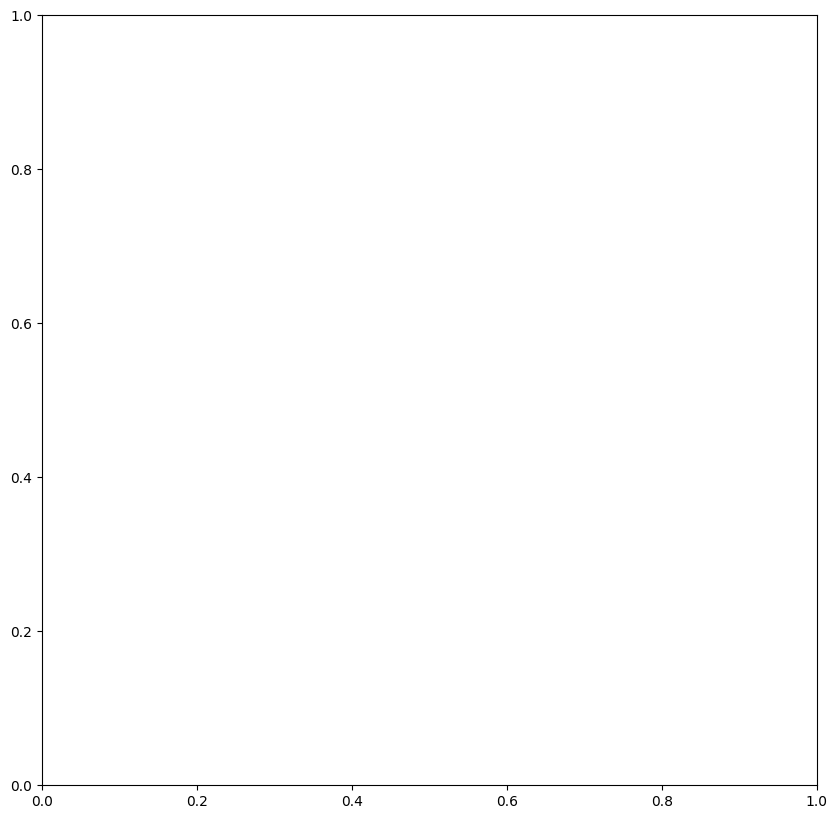

In [183]:
agebs_colima.plot(column="sum", figsize=(10,10), legend=True)
plt.show()